# **SkinCancerClasification - With Scaling and more Optimisations**


## **Import libraries, read dataset**

In [1]:
# Import our dependencies
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pandas as pd
import tensorflow as tf
# Keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
# Sklearn scaling
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv('https://mlee22ph.github.io/Project4_Group11_AR_GP_ML/Resources/hmnist_28_28_RGB.csv')
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [3]:
y = data['label']
x = data.drop(columns = ['label'])

In [4]:
tabular_data = pd.read_csv('https://mlee22ph.github.io/Project4_Group11_AR_GP_ML/Resources/HAM10000_metadata.csv')
tabular_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
tabular_data.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')

In [6]:
classes = {4: ('nv', ' melanocytic nevi'), 6: ('mel', 'melanoma'), 2 :('bkl', 'benign keratosis-like lesions'),
           1:('bcc' , ' basal cell carcinoma'), 5: ('vasc', ' pyogenic granulomas and hemorrhage'), 0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}


## **Model Analysis and Prediction**

In [7]:
x.shape

(10015, 2352)

In [8]:
y.shape

(10015,)

### **Use RandomOverSampler**

In [9]:
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)

In [10]:
#x = np.array(x).reshape(-1,28,28,3)
print('After RandomOverSampler - Shape of X :',x.shape)
print('After RandomOverSampler - Shape of Y :',y.shape)

After RandomOverSampler - Shape of X : (46935, 2352)
After RandomOverSampler - Shape of Y : (46935,)


### **Standardization and Splitting Data**

In [11]:
# This process is often referred to as z-score normalization or standardization.
x = (x-np.mean(x))/np.std(x)
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=1)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [12]:
print("Training Shape:", X_train.shape)
print("Testing Shape:", X_test.shape)

Training Shape: (37548, 2352)
Testing Shape: (9387, 2352)


### **Scaling and Normalization**

In [13]:
# Next, we normalize our training data to be between 0 and 1
scaler = MinMaxScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### **Create Sequential Model**

**With 100 units and 50 epochs:**

294/294 - 1s - loss: 0.5935 - accuracy: 0.7836 - 912ms/epoch - 3ms/step
Loss: 0.5934981107711792, Accuracy: 0.7836369276046753

In [14]:
# Increased units from 64 to 100
num_classes = 100

# Create an empty sequential model
model = Sequential()
# Add the first layer where the input dimensions are the 784 pixel values
# We can also choose our activation function. `relu` is a common
model.add(Dense(num_classes, activation='relu', input_dim=X_train.shape[1]))
# Add a second hidden layer
model.add(Dense(num_classes, activation='relu'))
# Add our final output layer where the number of nodes
# corresponds to the number of y labels
model.add(Dense(7, activation='softmax'))

In [15]:
# We can summarize our model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               235300    
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 7)                 707       
                                                                 
Total params: 246107 (961.36 KB)
Trainable params: 246107 (961.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### **Compile Model using sparse_categorical_crossentropy, meaning no need for One Hot Encoding**

In [16]:
# Sparse categorical cross-entropy is an extension of the categorical cross-entropy loss function that is used when the output labels are represented in a sparse matrix format.
# In a sparse matrix format, the labels are represented as a single index value rather than a one-hot encoded vector. This means that the labels are integers rather than vectors.
# Both categorical cross-entropy and sparse categorical cross-entropy have the same loss function as defined above. The only difference between the two is in how labels are defined.
# Hint: your output layer in this example is using software for logistic regression (categorical)
# If your output layer activation was `linear` then you may want to use `mse` for loss
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
# Increased epochs from 50 to 100
# Fit (train) the model
history = model.fit(
    X_train,
    Y_train,
    epochs=100,
    shuffle=True,
    verbose=2
)

Epoch 1/100
1174/1174 - 7s - loss: 1.6255 - accuracy: 0.3504 - 7s/epoch - 6ms/step
Epoch 2/100
1174/1174 - 7s - loss: 1.3916 - accuracy: 0.4516 - 7s/epoch - 6ms/step
Epoch 3/100
1174/1174 - 6s - loss: 1.2955 - accuracy: 0.4945 - 6s/epoch - 5ms/step
Epoch 4/100
1174/1174 - 10s - loss: 1.2388 - accuracy: 0.5174 - 10s/epoch - 8ms/step
Epoch 5/100
1174/1174 - 6s - loss: 1.1868 - accuracy: 0.5402 - 6s/epoch - 5ms/step
Epoch 6/100
1174/1174 - 7s - loss: 1.1559 - accuracy: 0.5572 - 7s/epoch - 6ms/step
Epoch 7/100
1174/1174 - 6s - loss: 1.1195 - accuracy: 0.5703 - 6s/epoch - 5ms/step
Epoch 8/100
1174/1174 - 7s - loss: 1.1028 - accuracy: 0.5755 - 7s/epoch - 6ms/step
Epoch 9/100
1174/1174 - 6s - loss: 1.0697 - accuracy: 0.5871 - 6s/epoch - 5ms/step
Epoch 10/100
1174/1174 - 7s - loss: 1.0577 - accuracy: 0.5933 - 7s/epoch - 6ms/step
Epoch 11/100
1174/1174 - 6s - loss: 1.0389 - accuracy: 0.5996 - 6s/epoch - 5ms/step
Epoch 12/100
1174/1174 - 6s - loss: 1.0184 - accuracy: 0.6092 - 6s/epoch - 5ms/step

In [18]:
# Evaluate the model using the test data
model_loss, model_accuracy = model.evaluate(X_test, Y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

294/294 - 1s - loss: 0.5363 - accuracy: 0.8003 - 1s/epoch - 3ms/step
Loss: 0.5363205671310425, Accuracy: 0.8002556562423706


## **Making Predictions and Classification Report**

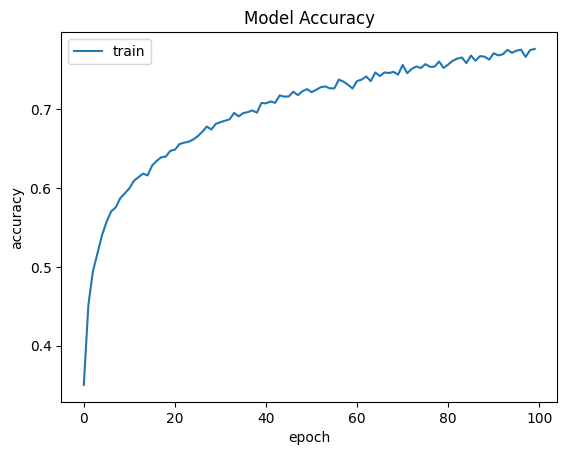

In [19]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("SkinCancerClasificationWithScalingMoreOptimisations-ModelAccuracy.png")
plt.show()

In [20]:
y_true = np.array(Y_test)
y_pred = model.predict(X_test)
y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
# Print result and prediction for side by side comparison
print(y_true)
print(y_pred)

294/294 [==============================] - 1s 4ms/step
[5 1 4 ... 2 6 0]
[5 3 4 ... 2 6 0]


In [21]:
from sklearn.metrics import confusion_matrix , classification_report

target_names = ["akiec", "bcc", "bkl", "df", "nv", "vasc", "mel"]
report = classification_report(y_true, y_pred, target_names=target_names)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.81      0.96      0.88      1359
         bcc       0.83      0.80      0.82      1318
         bkl       0.64      0.54      0.58      1262
          df       0.91      1.00      0.95      1351
          nv       0.76      0.60      0.67      1374
        vasc       0.96      1.00      0.98      1358
         mel       0.64      0.69      0.66      1365

    accuracy                           0.80      9387
   macro avg       0.79      0.80      0.79      9387
weighted avg       0.79      0.80      0.79      9387



In [22]:
# Print confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(
    cm, index=["Actual akiec", "bcc", "bkl", "df", "nv", "vasc", "mel"], columns=["Predicted akiec", "bcc", "bkl", "df", "nv", "vasc", "mel"]
)
display(cm_df)

,Predicted akiec,bcc,bkl,df,nv,vasc,mel
Actual akiec,1308,33,7,8,0,0,3
bcc,142,1053,50,26,10,18,19
bkl,89,77,676,39,122,7,252
df,0,0,0,1351,0,0,0
nv,45,60,114,41,829,23,262
vasc,0,0,0,0,0,1358,0
mel,29,42,206,16,125,10,937


## **Saving and Loading models**

In [23]:
# Save the model
model.save("SkinCancerClasificationWithScalingMoreOptimisations.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
# Load the model
from tensorflow.keras.models import load_model
model = load_model("SkinCancerClasificationWithScalingMoreOptimisations.h5")